In [2]:
import pandas as pd
import numpy as np
from scipy import stats

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import RFE

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [6]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [7]:
import pickle

<br />

**FilePaths**

In [8]:
raw_file_path = r'/home/alahira/Documents/Data science projects/Income_predictions/Datasets/raw/'
processed_file_path = r'/home/alahira/Documents/Data science projects/Income_predictions/Datasets/processed/'
model_path = r'/home/alahira/Documents/Data science projects/Income_predictions/Models/'

## DATA PREPROCESSING

In [9]:
#Create column labels to be passed to pandas dataframe
labels= ['age','work_class','fnlwgt','education','years_of_education','marital_status','occupation','relationship','race'
         ,'sex','capital_gain','capital_loss','hours_per_week','native_country','target']

#load dataset 
income = pd.read_csv(raw_file_path + 'adult.csv', names=labels)

In [10]:
## typecasting

income['work_class'] = income['work_class'].astype('category')
income['education'] = income['education'].astype('category')
income['marital_status'] = income['marital_status'].astype('category')
income['occupation'] = income['occupation'].astype('category')
income['relationship'] = income['relationship'].astype('category')
income['race'] = income['race'].astype('category')
income['sex'] = income['sex'].astype('category')
income['native_country'] = income['native_country'].astype('category')
income['target'] = income['target'].astype('category')

print('Typecasting operations completed successfullty')

Typecasting operations completed successfullty


In [11]:
##seperate numeric and categorical variables for handling

numeric_vars = income.select_dtypes(exclude = ('category','object'))
cat_vars = income.select_dtypes(include = ('category','object'))

In [12]:
cat_vars.drop(labels='target', inplace = True, axis = 1)
cat_vars.head(5)

,work_class,education,marital_status,occupation,relationship,race,sex,native_country
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba


In [13]:
numeric_vars.head(5)

,age,fnlwgt,years_of_education,capital_gain,capital_loss,hours_per_week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


<br />

**Handle Categorical Data**

In [14]:
dummy_vars = pd.get_dummies(data = cat_vars)

In [15]:
dummy_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Columns: 102 entries, work_class_ ? to native_country_ Yugoslavia
dtypes: uint8(102)
memory usage: 3.2 MB


<br />

**Handle Numeric Variables**

In [16]:
#instantiate standard scaler
scaler = StandardScaler()

In [17]:
scaled_numeric_vars = scaler.fit_transform(numeric_vars)

In [18]:
scaled_numeric_vars = pd.DataFrame(data = scaled_numeric_vars, columns= numeric_vars.columns)

In [19]:
scaled_numeric_vars.head(5)

,age,fnlwgt,years_of_education,capital_gain,capital_loss,hours_per_week
0,0.030671,-1.063611,1.134739,0.148453,-0.21666,-0.035429
1,0.837109,-1.008707,1.134739,-0.145920,-0.21666,-2.222153
2,-0.042642,0.245079,-0.420060,-0.145920,-0.21666,-0.035429
3,1.057047,0.425801,-1.197459,-0.145920,-0.21666,-0.035429
4,-0.775768,1.408176,1.134739,-0.145920,-0.21666,-0.035429


In [20]:
##instantiate binarizer
binarize = Binarizer()

In [21]:
#binarize capital_gain and capital_loss variables

scaled_numeric_vars['capital_gain'] = binarize.fit_transform(scaled_numeric_vars['capital_gain'].values.reshape(-1,1))
scaled_numeric_vars['capital_loss'] = binarize.fit_transform(scaled_numeric_vars['capital_loss'].values.reshape(-1,1))

In [22]:
scaled_numeric_vars['capital_gain'].head(5)

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: capital_gain, dtype: float64

In [23]:
## merge dataframe
new_df = pd.merge(left=scaled_numeric_vars, right=dummy_vars, left_index=True, right_index=True)

In [24]:
#encode target variable and add to new_df
encoder = LabelEncoder()
new_df['target'] = encoder.fit_transform(income['target'])

<br />

**Remove Outliers**

In [25]:
##get z_score of elements in the data and remove element if z_score is 3 and above
z = np.abs(stats.zscore(new_df))
new_df_3 = new_df[(z < 3).all(axis=1)]

##get z_score of elements in the data and remove element if z_score is 4 and above
z = np.abs(stats.zscore(new_df))
new_df_4 = new_df[(z < 4).all(axis=1)]

##get z_score of elements in the data and remove element if z_score is 5 and above
z = np.abs(stats.zscore(new_df))
new_df_5 = new_df[(z < 5).all(axis=1)]

In [26]:
print(f'shape of data before outlier removal is {income.shape}')
print(f'shape of data after removing outliers with z_score of 3 and above is {new_df_3.shape}')
print(f'shape of data after removing outliers with z_score of 4 and above is {new_df_4.shape}')
print(f'shape of data after removing outliers with z_score of 5 and above is {new_df_5.shape}')

shape of data before outlier removal is (32561, 15)
shape of data after removing outliers with z_score of 3 and above is (7447, 109)
shape of data after removing outliers with z_score of 4 and above is (11492, 109)
shape of data after removing outliers with z_score of 5 and above is (18226, 109)


<br />

**Resample data with outliers of z_score of 3 and above removed**

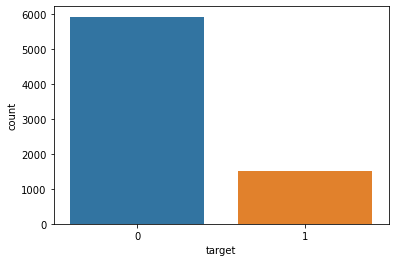

In [27]:
sns.countplot(new_df_3['target'])

In [28]:
# target variable is inbalanced and would haffect the predictive algorithm there it has to be resampled

#oversample minority class to 75 percent of majority class
over = SMOTE(sampling_strategy=0.75)
under = RandomUnderSampler()

## create resampling pipeline
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

y = new_df_3['target']
x = new_df_3.drop(labels = 'target', axis = 1)

## fit and resample dataset
x, y= pipeline.fit_resample(x, y)

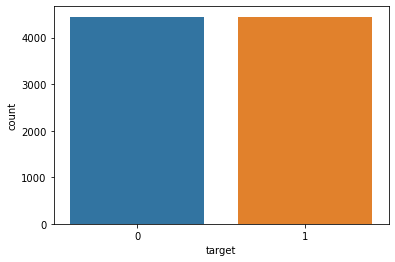

In [29]:
sns.countplot(y)

In [30]:
##split dataset into testing and training data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.80, random_state = 10)

In [31]:
#instantiate logisticregression algorithm
log_reg = LogisticRegression(solver = 'liblinear')

<br />

**Feature selection for logistic regression algorithm using Recursive Feature Elimination**

In [32]:
#recursively eliminate 1 feature after every pass till only the 10 most
#important features are left and save

rfe_log_reg = RFE(estimator= log_reg, n_features_to_select=10, step = 1 )
rfe_log_reg.fit(x_train, y_train)
x_train_3_selected = rfe_log_reg.transform(x_train)
x_test_3_selected = rfe_log_reg.transform(x_test)

In [33]:
#print shape of dataframe before and after recursive elimination
print(f'shape of x_train before selection : {x_train.shape}')
print(f'shape of x_train after selection : {x_train_3_selected.shape}')

shape of x_train before selection : (1779, 108)
shape of x_train after selection : (1779, 10)


In [34]:
#train model
def train_model(algorithm, x_train, y_train, x_test, y_test):
    """Train algorithm and return trained model"""
    
    #train algorithm and make predicitons
    algorithm.fit(x_train,y_train)
    algo_preds = algorithm.predict(x_test)
    
    #check metrics
    c_matrix = confusion_matrix(y_test, algo_preds)
    report = classification_report(y_test, algo_preds)
    
    return algorithm, report, c_matrix

In [35]:
log_reg_model_one, class_report, c_matrix = train_model(log_reg, x_train_3_selected, y_train, x_test_3_selected, y_test)

In [36]:
#print confusion_matrix and classification_report
print(c_matrix,'\n')
print('\n', class_report)

[[2702  875]
 [ 375 3167]] 


               precision    recall  f1-score   support

           0       0.88      0.76      0.81      3577
           1       0.78      0.89      0.84      3542

    accuracy                           0.82      7119
   macro avg       0.83      0.82      0.82      7119
weighted avg       0.83      0.82      0.82      7119



<br />

**Resample data with outliers of z_score of 3 and above removed**

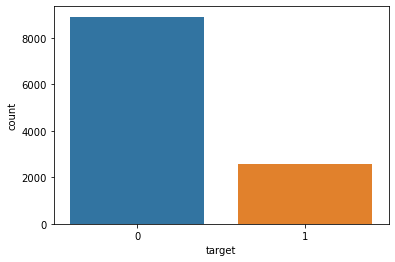

In [37]:
sns.countplot(new_df_4['target'])

In [38]:
y = new_df_4['target']
x = new_df_4.drop(labels = 'target', axis = 1)

## fit and resample dataset
x, y= pipeline.fit_resample(x, y)

In [39]:
##split dataset into testing and training data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.80, random_state = 10)

In [40]:
#recursively eliminate 1 feature after every pass till only the 10 most
#important features are left and save
rfe_log_reg.fit(x_train, y_train)
x_train_4_selected = rfe_log_reg.transform(x_train)
x_test_4_selected = rfe_log_reg.transform(x_test)

In [41]:
#print shape of dataframe before and after recursive elimination
print(f'shape of x_train before selection : {x_train.shape}')
print(f'shape of x_train after selection : {x_train_4_selected.shape}')

shape of x_train before selection : (2674, 108)
shape of x_train after selection : (2674, 10)


In [42]:
log_reg_model_two, class_report, c_matrix = train_model(log_reg, x_train_4_selected, y_train, x_test_4_selected, y_test)

In [43]:
#print confusion_matrix and classification_report
print(c_matrix,'\n')
print('\n', class_report)

[[3746 1608]
 [ 556 4788]] 


               precision    recall  f1-score   support

           0       0.87      0.70      0.78      5354
           1       0.75      0.90      0.82      5344

    accuracy                           0.80     10698
   macro avg       0.81      0.80      0.80     10698
weighted avg       0.81      0.80      0.80     10698



<br />

**NB**

From the classification report of the first and second model, it is obvious that the first model is slightly better. It would therefore be used 

In [44]:
#serialize model and column data for deployment
filename ='logistic_regression_model_one.sav'
column_data_name = 'column_data'

pickle.dump(log_reg_model_one, open(model_path + filename,'wb'))
pickle.dump(rfe_log_reg, open(model_path + column_data_name,'wb'))
